C:\Users\Benjamin\anaconda3\lib\site-packages\skimage\filters\rank\generic.py:118: UserWarning: Possible precision loss converting image of type float64 to uint8 as required by rank filters. Convert manually using skimage.util.img_as_ubyte to silence this warning.
  image, selem, out, mask, n_bins = _handle_input(image, selem, out, mask,
Lossy conversion from float64 to uint8. Range [-0.08237163814180937, 1.0]. Convert image to uint8 prior to saving to suppress this warning.


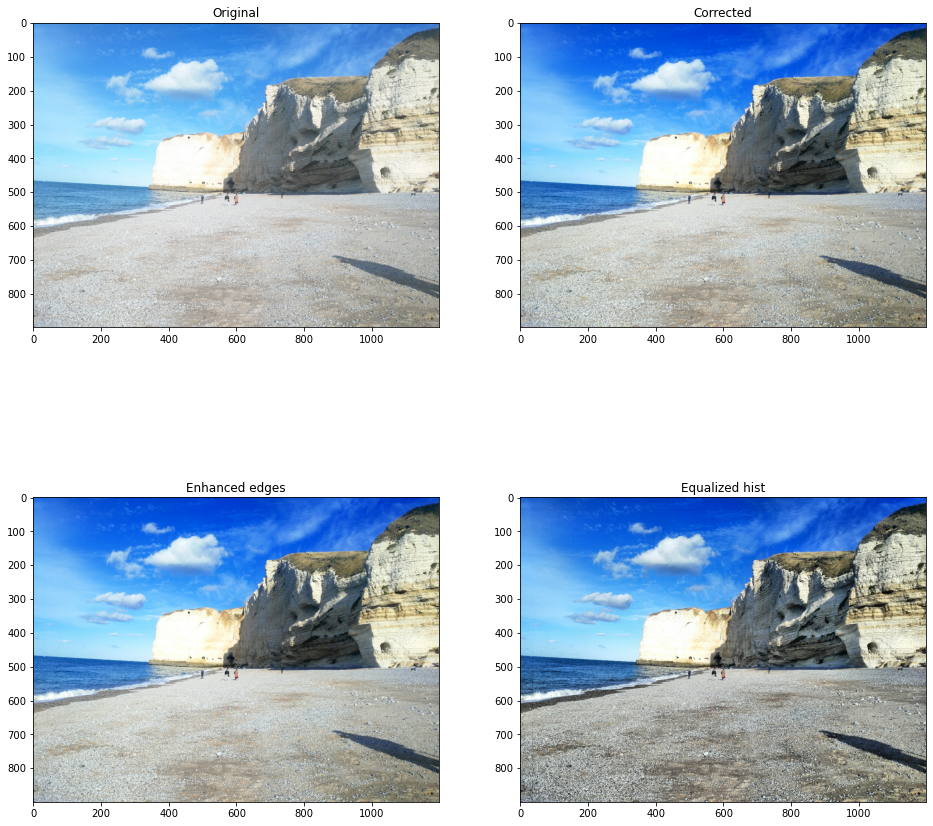

In [367]:
from skimage.io import imread,imshow,imsave
import numpy as np
import matplotlib.pyplot as plt
from skimage.color import rgb2hsv,hsv2rgb
from skimage.filters import sobel, gaussian
from skimage.feature import canny
from skimage.exposure import equalize_adapthist as equa

%matplotlib inline


im = imread('etretat.jpg')

im2 = im.copy()

def get95perc(hist):
    c_hist = np.zeros(256)
    for i in range(255):
        c_hist[i] = c_hist[i-1] + hist[i]
    minimum = np.min([(c_hist<0.03).sum(),40])
    maximum = np.max([(c_hist<0.97).sum(),215])
    return minimum,maximum

def correctColorRange(C):
    Tmin,Tmax = get95perc(np.histogram(C.flatten(),range(256),density = 1)[0])
    
    lut_al = np.arange(256)
    lut_al[lut_al>Tmax] = 255
    lut_al[lut_al<Tmin] = 0
    lut_al[(lut_al<=Tmax)*(lut_al>=Tmin)] = 255/(Tmax-Tmin) * (lut_al[(lut_al<=Tmax)*(lut_al>=Tmin)] - Tmin)
    
    C = lut_al[C]
    return C

R = correctColorRange(im2[:,:,0])
G = correctColorRange(im2[:,:,1])
B = correctColorRange(im2[:,:,2])


hist_r,bins_r = np.histogram(R.flatten(),range(256),density = 1)
hist_g,bins_g = np.histogram(G.flatten(),range(256),density = 1)
hist_b,bins_b = np.histogram(B.flatten(),range(256),density = 1)

im2[:,:,0] = R
im2[:,:,1] = G
im2[:,:,2] = B

im_hsv = rgb2hsv(im2)

im_hsv[:,:,0] = im_hsv[:,:,0]*1.03
im_hsv[:,:,1] = im_hsv[:,:,1]*1.1
im_hsv[:,:,2] = im_hsv[:,:,2]

im2 = hsv2rgb(im_hsv)

border_canny = np.zeros((im.shape[0],im.shape[1]))
border_canny = (canny(median(im2[:,:,0],disk(15))) + canny(median(im2[:,:,1],disk(15)))+canny(median(im2[:,:,2],disk(15))))

im3 = im2.copy()
im3[border_canny] = im2[border_canny]/1.05

im4 = equa(im3,clip_limit=0.008, kernel_size = 75)

imsave('etretat_final.jpg', im4)


plt.figure(figsize=(16,16))
plt.subplot(2,2,1)
plt.imshow(im)
plt.title('Original')
plt.subplot(2,2,2)
plt.imshow(np.clip(im2,0,255))
plt.title('Corrected')
plt.subplot(2,2,3)
plt.imshow(np.clip(im3,0,255))
plt.title('Enhanced edges')
plt.subplot(2,2,4)
plt.imshow(np.clip(im4,0,255))
plt.title('Equalized hist')
plt.show()


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


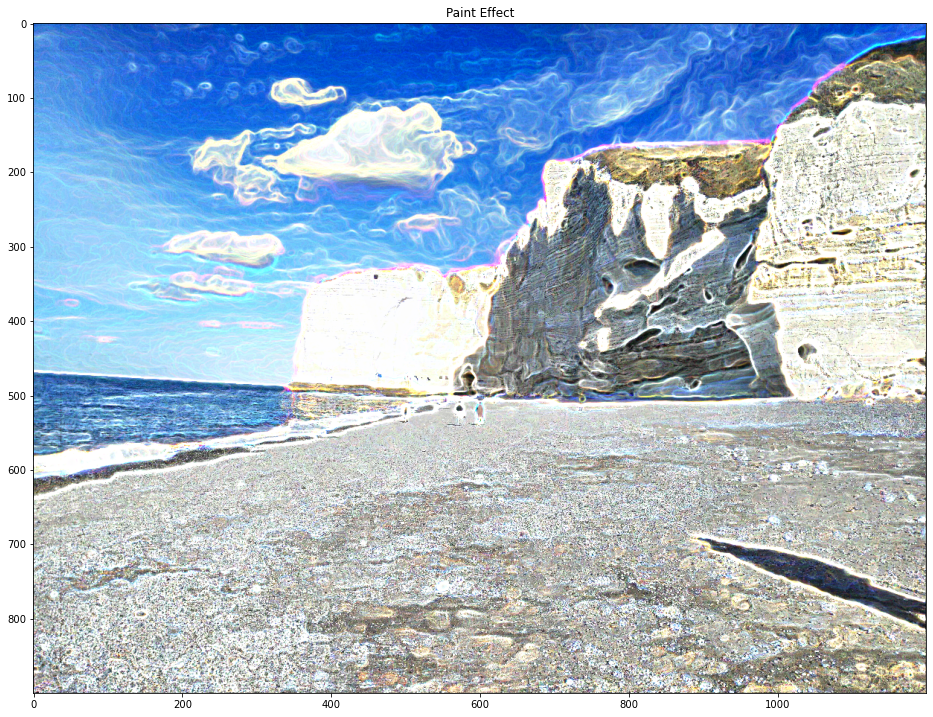

In [363]:
border_sobel = np.zeros(im2.shape)

border_sobel[:,:,0] = sobel(median(im2[:,:,0],disk(5)))
border_sobel[:,:,1] = sobel(median(im2[:,:,1],disk(5)))
border_sobel[:,:,2] = sobel(median(im2[:,:,2],disk(5)))

paint = im4.astype('float')+15*border_sobel
paint = np.clip(paint,0,1)
imsave('etretat_paint.jpg',paint)

plt.figure(figsize=(16,16))
plt.imshow(paint)
plt.title('Paint Effect')
plt.show()

Lossy conversion from float64 to uint8. Range [0.0, 1.351]. Convert image to uint8 prior to saving to suppress this warning.
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


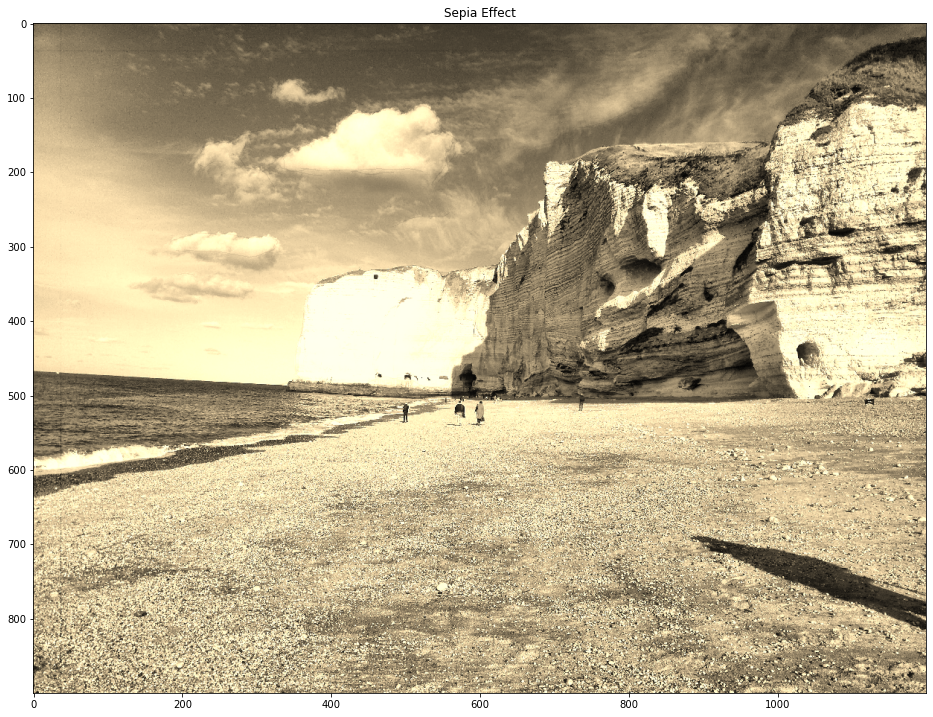

In [284]:
sepia = im4.copy()

sepia[:,:,0]= im4[:,:,0]*0.393 + im4[:,:,1]*0.769 + im4[:,:,2]*0.189
sepia[:,:,1]= im4[:,:,0]*0.349 + im4[:,:,1]*0.686 + im4[:,:,2]*0.168
sepia[:,:,2]= im4[:,:,0]*0.272 + im4[:,:,1]*0.534 + im4[:,:,2]*0.131

imsave('etretat_sepia.jpg',sepia)
plt.figure(figsize=(16,16))
plt.imshow(sepia)
plt.title('Sepia Effect')
plt.show()

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


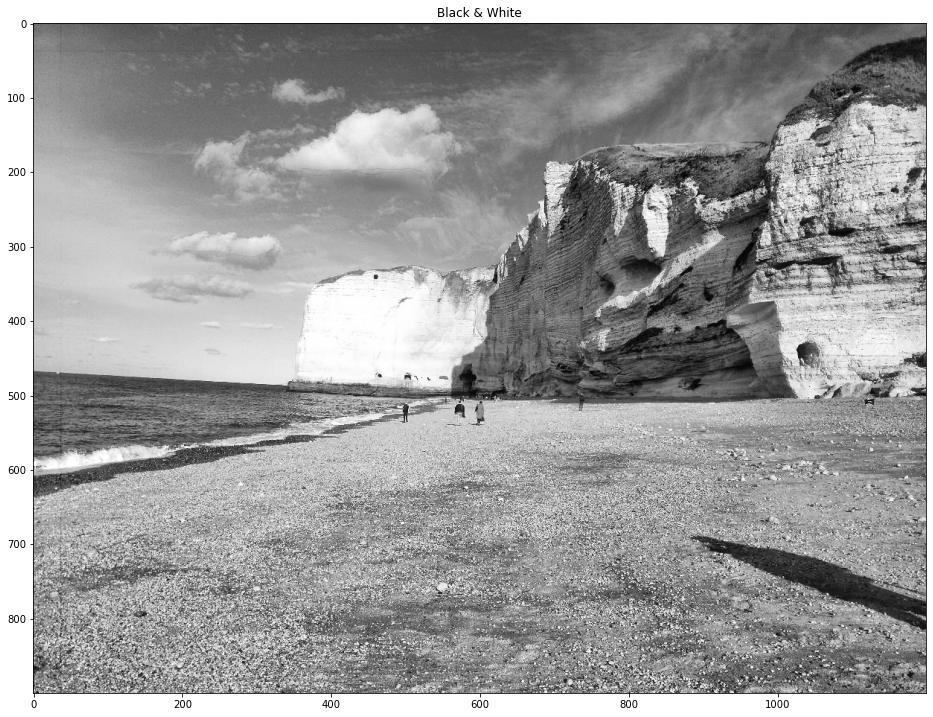

In [285]:
bw = (im4[:,:,0] + im4[:,:,1] + im4[:,:,2])/3

imsave('etretat_bw.jpg',bw)

plt.figure(figsize=(16,16))
plt.imshow(bw)
plt.title('Black & White')
plt.show()

<ipython-input-365-f69d8d2b5c74>:17: UserWarning: etretat_pencil.jpg is a low contrast image
  imsave('etretat_pencil.jpg',pencil)


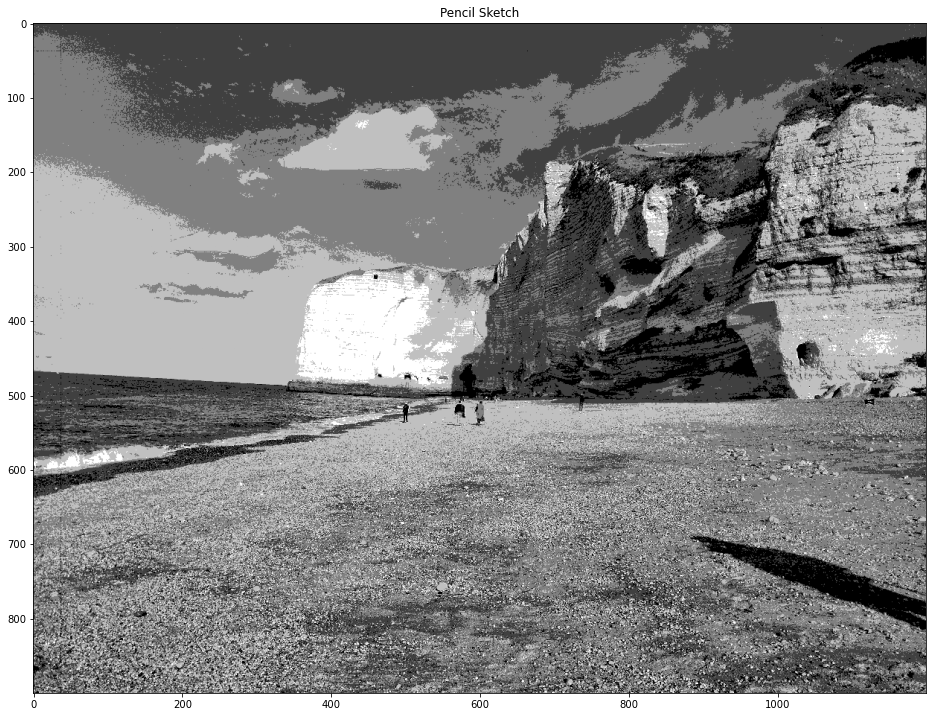

In [365]:
mask = mean(bw, disk(0))


lut = np.arange(255,-1,-1)
mask = lut[mask]
mask = gaussian(mask, sigma = 20)

def dodge(i,m):
    result=i*4.2*255/(255-m)
    result[result>255]=255
    result[m==255]=255 
    return result.astype('uint8')
    
    
pencil = dodge(bw,mask)

imsave('etretat_pencil.jpg',pencil)

plt.figure(figsize=(16,16))
plt.imshow(pencil)
plt.title('Pencil Sketch')
plt.show()

<ipython-input-335-fd0816afae98>:5: UserWarning: etretat_sketch.jpg is a low contrast image
  imsave('etretat_sketch.jpg',sketch)
Lossy conversion from int32 to uint8. Range [78, 255]. Convert image to uint8 prior to saving to suppress this warning.


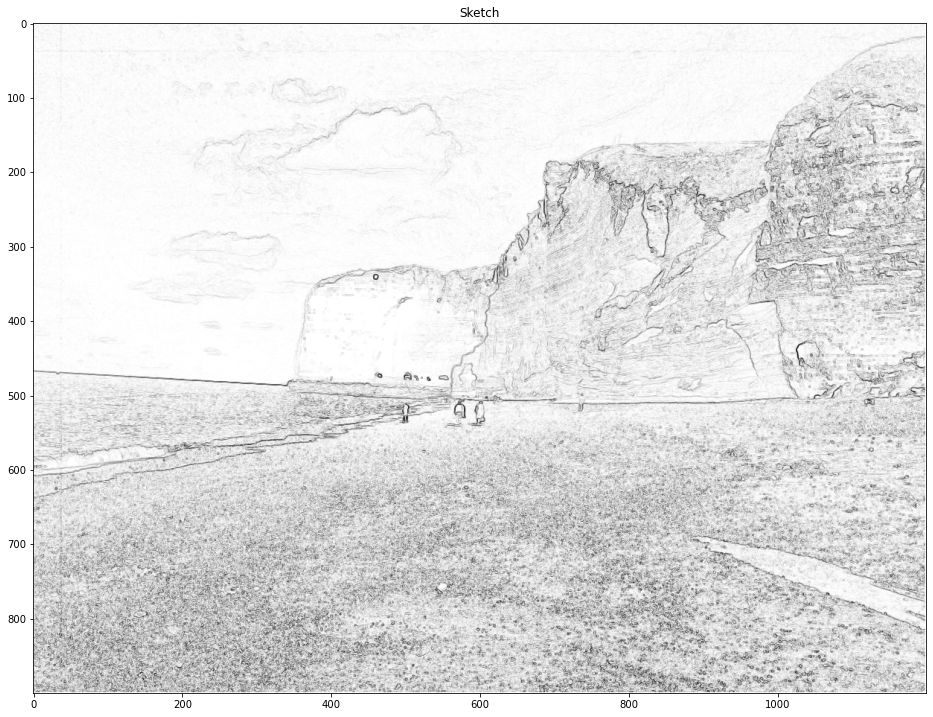

In [335]:
sketch = (sobel(bw)*256).astype('uint8')

sketch = lut[sketch]

imsave('etretat_sketch.jpg',sketch)

plt.figure(figsize=(16,16))
plt.imshow(sketch)
plt.title('Sketch')
plt.show()

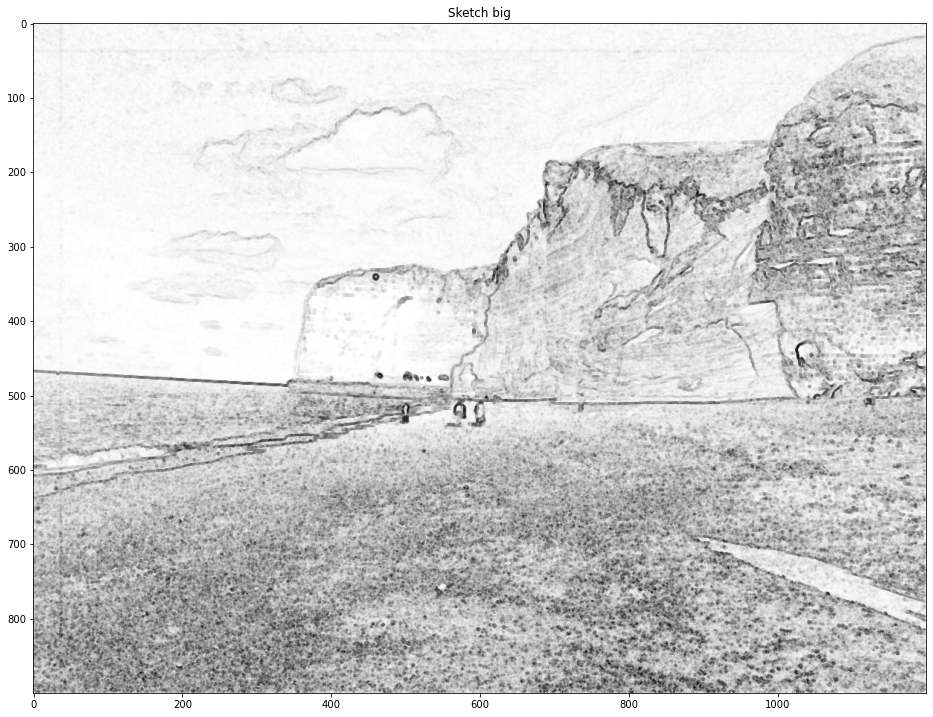

In [337]:
import skimage.filters.rank as skr
big_sketch = (sobel(bw)*256).astype('uint8')

big_sketch = skr.maximum(big_sketch, disk(1))

big_sketch = lut[big_sketch]

imsave('etretat_sketch_big.jpg',big_sketch.astype('uint8'))

plt.figure(figsize=(16,16))
plt.imshow(big_sketch)
plt.title('Sketch big')
plt.show()